In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

In [31]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [32]:
def boxplots(X,y):
  data = pd.concat([pd.DataFrame(y, columns=['target']), pd.DataFrame(X, columns=['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10',])], axis=1)

  num_features = X.shape[1]
  num_rows = num_features // 3 + 1

  fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
  fig.subplots_adjust(hspace=0.5)

  # Se recorre cada feature para generar su diagrama de caja respecto de la salida
  for i, feature in enumerate(data.columns[1:]):
      row = i // 3
      col = i % 3
      sns.boxplot(x='target', y=feature, data=data, ax=axes[row, col])
      axes[row, col].set_title(f'Diagrama de caja de {feature}')
      axes[row, col].set_xlabel('Target')
      axes[row, col].set_ylabel(feature)

  # Eliminar subplots vacíos si es necesario
  if num_features % 3 != 0:
      for i in range(num_features % 3, 3):
          fig.delaxes(axes[num_rows - 1, i])

  plt.show()


In [33]:
def grafica_recta_decision(logistic_model, title, X, y):
  # Obtener los coeficientes del modelo para la recta de decisión
  coef = logistic_model.coef_
  intercept = logistic_model.intercept_

  # Visualizar los datos y la frontera de decisión del modelo con probabilidades y recta
  plt.figure(figsize=(4,4))

  # Graficar las probabilidades de pertenencia a la clase 1 (positiva)
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, marker='o')
  ax = plt.gca()
  plt.xlabel('Característica 1')
  plt.ylabel('Característica 2')
  plt.title(title)

  xlim = ax.get_xlim()
  ylim = ax.get_ylim()

  # Graficar la recta de decisión
  xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
  plt.contour(xx, yy, logistic_model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape), levels=[0], linewidths=2, colors='k')

  plt.tight_layout()
  plt.show()

In [34]:
X, y = make_classification(n_samples=1000, n_features=10, weights=[0.9, 0.1], random_state=42)

### Al generarse de esta forma no hay datos faltantes

In [35]:
len(y[y==1]), len(y[y==0])

(103, 897)

In [36]:
pd.Series(y).value_counts()

,count
0,897
1,103


vemos efectivamente el desbalance de clases: sólo hay un 10% de datos etiquetados con la clase 1.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
pd.Series(y_train).value_counts()

,count
0,722
1,78


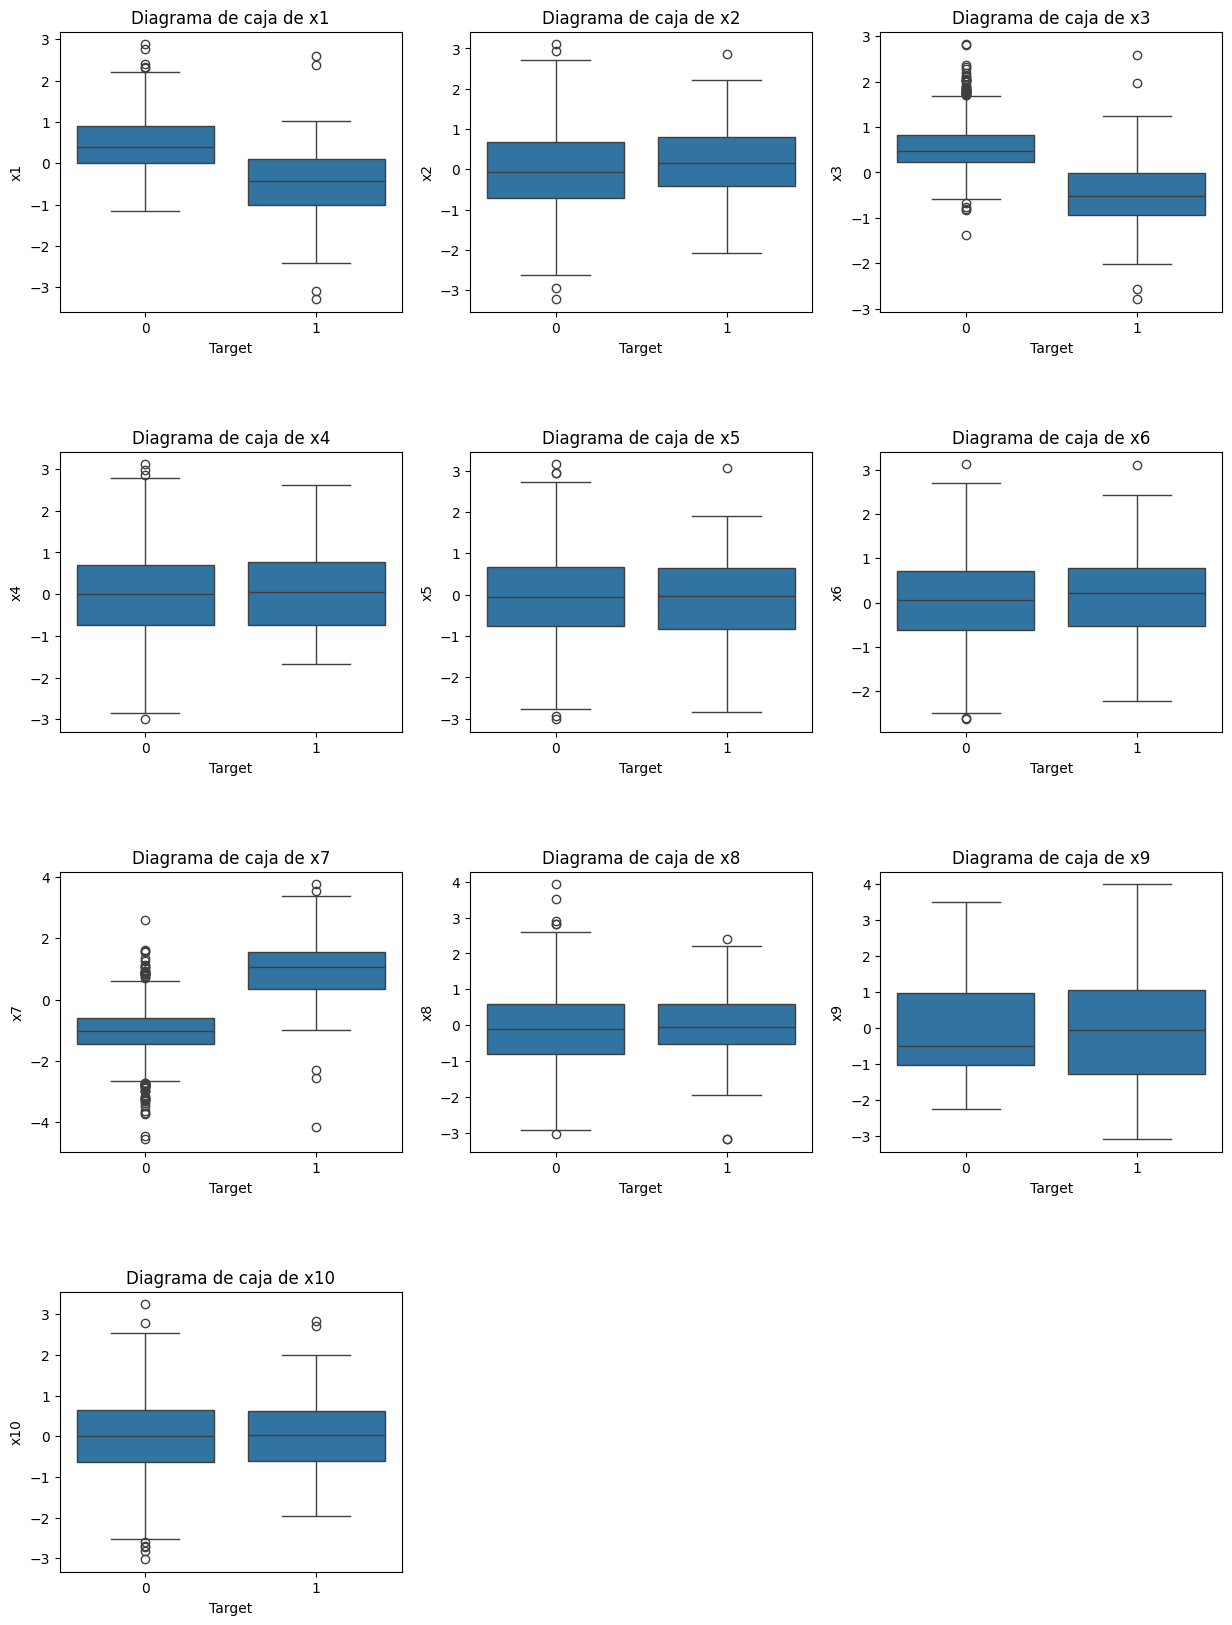

In [38]:
boxplots(X_train, y_train)

In [39]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

print("Resultados con regresión logística\n")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

#### The support is the number of occurrences of each class in y_true.

Resultados con regresión logística

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       175
           1       0.67      0.48      0.56        25

    accuracy                           0.91       200
   macro avg       0.80      0.72      0.75       200
weighted avg       0.90      0.91      0.90       200

[[169   6]
 [ 13  12]]


In [40]:
logistic_model = LogisticRegression(random_state=42, class_weight='balanced')
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

print("Resultados con regresión logística\n")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

#### Class_weight = 'balanced' le asigna pesos distintos en el cálculo de costo para cada clase. En este caso, como la relación de datos es 90/10
#### el error de la clase de pocos datos penaliza 9 veces más que el de la clase de muchos datos.

Resultados con regresión logística

              precision    recall  f1-score   support

           0       0.98      0.86      0.92       175
           1       0.48      0.88      0.62        25

    accuracy                           0.86       200
   macro avg       0.73      0.87      0.77       200
weighted avg       0.92      0.86      0.88       200

[[151  24]
 [  3  22]]


In [41]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("Resultados para un Random Forest\n:")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Resultados para un Random Forest
:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       175
           1       0.88      0.60      0.71        25

    accuracy                           0.94       200
   macro avg       0.91      0.79      0.84       200
weighted avg       0.94      0.94      0.93       200

[[173   2]
 [ 10  15]]


In [42]:
# Remuestreo con Oversampling (RandomOverSampler)
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html

oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

In [43]:
len(y_resampled[y_resampled==1]), len(y_resampled[y_resampled==0])

### El oversampler no hizo nada con los datos que tienen y=1, pero sí generó muchos datos nuevos con y=0.

(722, 722)

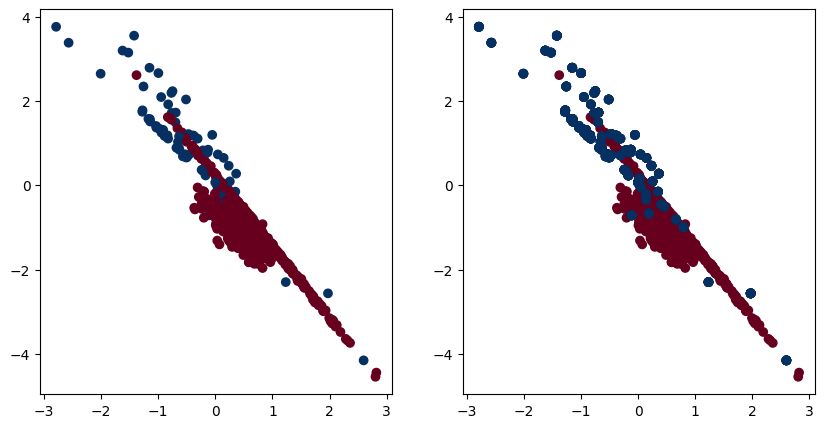

In [59]:
### Hacemos dos gráficas, la de la izquierda tendrá los datos sin resamplear y la de la derecha los datos resampleados.
### Lo vamos a ver solo con dos features porque sino es imposible de graficar.

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].scatter(X_train[:, 2], X_train[:, 6], c=y_train, cmap=plt.cm.RdBu)
ax[1].scatter(X_resampled[:, 2], X_resampled[:, 6], c=y_resampled, cmap=plt.cm.RdBu)
plt.show()

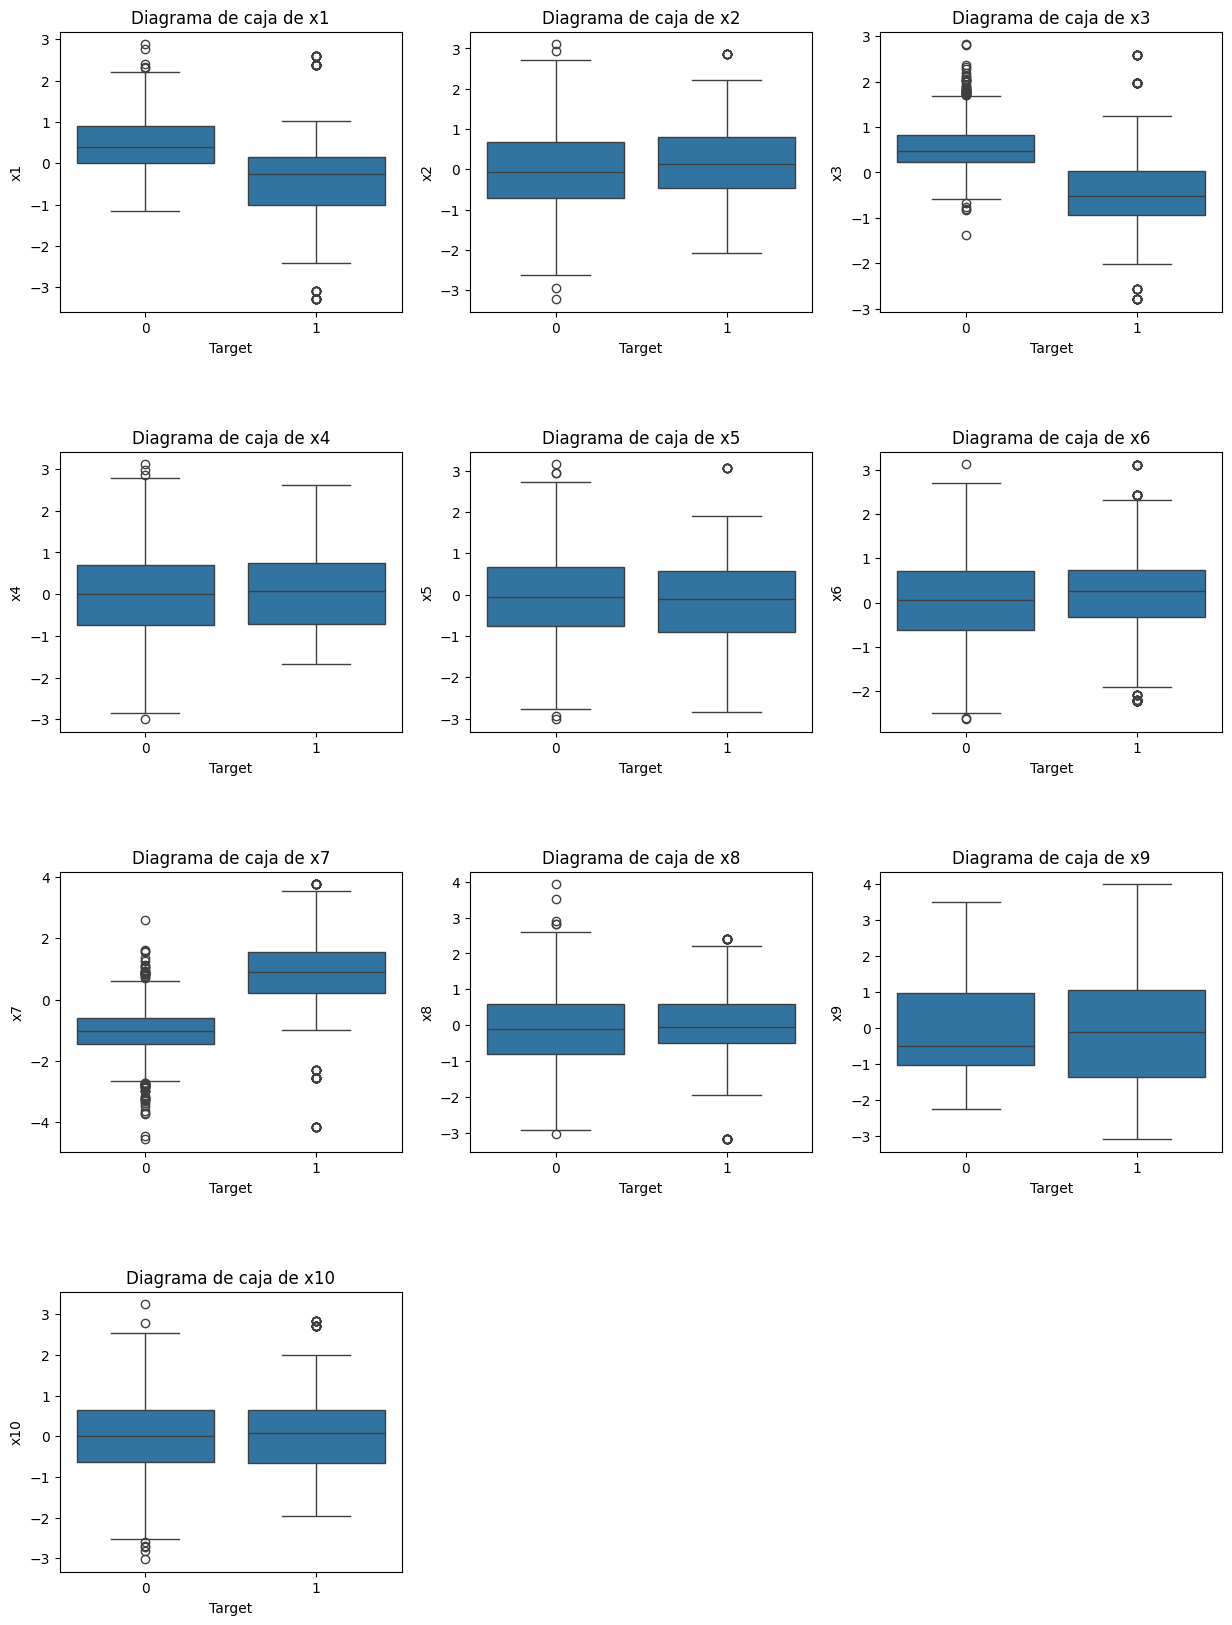

In [45]:
boxplots(X_resampled, y_resampled)

In [46]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_resampled, y_resampled)
y_pred = logistic_model.predict(X_test)

print("Resultados regresión logística con Oversampling:\n")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Resultados regresión logística con Oversampling:

              precision    recall  f1-score   support

           0       0.98      0.85      0.91       175
           1       0.46      0.88      0.60        25

    accuracy                           0.85       200
   macro avg       0.72      0.87      0.76       200
weighted avg       0.92      0.85      0.87       200

[[149  26]
 [  3  22]]


In [47]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)
y_pred = rf_model.predict(X_test)

print("Resultados para un Random Forest con Oversampling:\n")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Resultados para un Random Forest con Oversampling:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       175
           1       0.85      0.68      0.76        25

    accuracy                           0.94       200
   macro avg       0.90      0.83      0.86       200
weighted avg       0.94      0.94      0.94       200

[[172   3]
 [  8  17]]


SMOTE

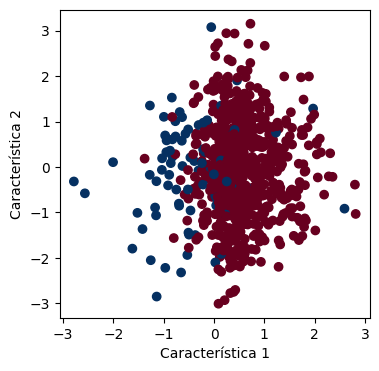

In [48]:
plt.figure(figsize=(4, 4))
plt.scatter(X_train[:, 2], X_train[:, 4], c=y_train, cmap=plt.cm.RdBu)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.show()

In [49]:
X_train_v2=np.column_stack((X_train[:,2],X_train[:,4]))
X_test_v2=np.column_stack((X_test[:,2],X_test[:,4]))

In [50]:
X_train_v2.shape

(800, 2)

In [51]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train_v2, y_train)
y_pred = logistic_model.predict(X_test_v2)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       175
           1       0.83      0.40      0.54        25

    accuracy                           0.92       200
   macro avg       0.88      0.69      0.75       200
weighted avg       0.91      0.92      0.90       200

[[173   2]
 [ 15  10]]


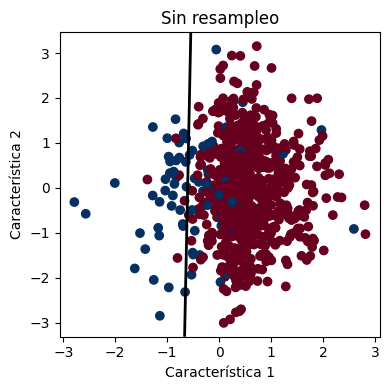

In [52]:
grafica_recta_decision(logistic_model, 'Sin resampleo', X_train_v2, y_train)

In [53]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_v2, y_train)

In [54]:
X_train_resampled.shape

(1444, 2)

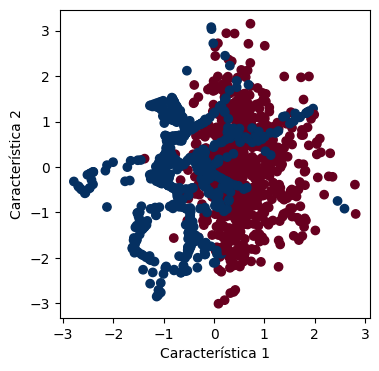

In [55]:
plt.figure(figsize=(4, 4))
plt.scatter(X_train_resampled[:, 0], X_train_resampled[:, 1], c=y_train_resampled, cmap=plt.cm.RdBu)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.show()

In [56]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train_resampled, y_train_resampled)
y_pred = logistic_model.predict(X_test_v2)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90       175
           1       0.41      0.80      0.54        25

    accuracy                           0.83       200
   macro avg       0.69      0.82      0.72       200
weighted avg       0.90      0.83      0.85       200

[[146  29]
 [  5  20]]


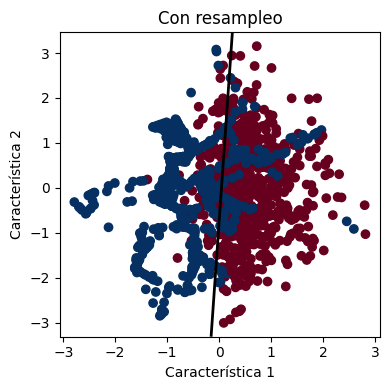

In [57]:
grafica_recta_decision(logistic_model, 'Con resampleo', X_train_resampled, y_train_resampled)

#### Probar, investigar, jugar además con:

### ADASYN, RandomUnderSampler, NearMiss

Utilizar la documentación de imbalance.
Un artículo con algo de info:
https://towardsdatascience.com/class-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a